In [1]:
import sys
import warnings
sys.path.append("../Pythonscripts")
sys.path.append(r"C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\Scripts")
import pandas as pd
import numpy as np
import synapseclient as sc
from pdkit_features import pdkit_normalize
warnings.simplefilter("ignore")

In [2]:
## login to synapse
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
## helper function
def fill(params):
    try:
        return float(params)
    except:
        return np.NaN
    
def data_to_float(train):
    for feat in train.columns:
        if feat != "healthCode" and feat != "PD":
            train[feat] = train[feat].astype(float) 
    return train

# Retrieve Data from Synapse

In [4]:
## get sfm data
entity = syn.get("syn20817213")
sfm_data = pd.read_csv(entity["path"], index_col = 0)
for feat in [feat for feat in sfm_data.columns if "sfm" in feat]:
    sfm_data[feat] = sfm_data[feat].apply(fill)
    

## get pdkit data
entity = syn.get("syn20817011")
pdkit_data = pd.read_csv(entity["path"], index_col = 0)

## filter data
filtered_entity = syn.get("syn8381056")
filtered_healthcode_data = pd.read_csv(filtered_entity["path"], sep = "\t")
filtered_healthcode_list = list(filtered_healthcode_data["healthCode"])

# Combine Outbound and Return Data

In [5]:
## combine outbound and return into the same feature to reduce feature space

walking_columns = [feat for feat in pdkit_data.columns if ("features" in feat) 
                   and ("outbound" in feat or "return" in feat)]

walking_data = pdkit_data[[feat for feat in pdkit_data.columns if (feat in walking_columns) 
                     or ("healthCode" in feat)]]

temp = walking_data.copy()

temp = temp.rename(columns = {"accel_return_features_x" : "accel_walking_features_x", 
                              "userAccel_return_features_x" : "userAccel_walking_features_x",
                              "accel_return_features_y" : "accel_walking_features_y", 
                              "userAccel_return_features_y" : "userAccel_walking_features_y",
                              "accel_return_features_z" : "accel_walking_features_z", 
                              "userAccel_return_features_z" : "userAccel_walking_features_z",
                              "accel_return_features_AA" : "accel_walking_features_AA", 
                              "userAccel_return_features_AA" : "userAccel_walking_features_AA"
                             })
walking_data = walking_data.rename(columns = {"accel_outbound_features_x" : "accel_walking_features_x", 
                              "userAccel_outbound_features_x" : "userAccel_walking_features_x",
                              "accel_outbound_features_y" : "accel_walking_features_y", 
                              "userAccel_outbound_features_y" : "userAccel_walking_features_y",
                              "accel_outbound_features_z" : "accel_walking_features_z", 
                              "userAccel_outbound_features_z" : "userAccel_walking_features_z",
                              "accel_outbound_features_AA" : "accel_walking_features_AA", 
                              "userAccel_outbound_features_AA" : "userAccel_walking_features_AA"
                             })

# Concatenate return and outbound data
walking_data = pd.concat([walking_data, temp], ignore_index = True)
walking_data = walking_data[[feat for feat in walking_data.columns if ("walking" in feat) or ("healthCode" in feat)]]
walking_data = pdkit_normalize(walking_data)

# Grouped Data per HealthCode

In [6]:
## group sfm data
mean_sfm_data = sfm_data.groupby("healthCode").mean()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
mean_sfm_data.columns = ["healthCode"] + ["mean_{}".format(_) for _ in mean_sfm_data.columns if "sfm" in _]
min_sfm_data = sfm_data.groupby("healthCode").min()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
min_sfm_data.columns = ["healthCode"] + ["min_{}".format(_) for _ in min_sfm_data.columns if "sfm" in _]
max_sfm_data = sfm_data.groupby("healthCode").max()[[feat for feat in sfm_data.columns if "sfm" in feat]].reset_index()
max_sfm_data.columns = ["healthCode"] + ["max_{}".format(_) for _ in max_sfm_data.columns if "sfm" in _]


mean_walking_data = walking_data.groupby("healthCode").mean()[["no_of_steps userAccel_walking_features_x",
                                                               "no_of_steps userAccel_walking_features_y",
                                                               "no_of_steps userAccel_walking_features_z",
                                                               "no_of_steps userAccel_walking_features_AA",
                                                               "speed_of_gait userAccel_walking_features_x",
                                                               "speed_of_gait userAccel_walking_features_y", 
                                                               "speed_of_gait userAccel_walking_features_z",
                                                               "speed_of_gait userAccel_walking_features_AA", 
                                                              "gait_step_regularity userAccel_walking_features_y"]].reset_index()

mean_walking_data.columns = ["healthCode"] + ["mean_{}".format(_) for _ in mean_walking_data.columns if "features" in _]

max_walking_data = walking_data.groupby("healthCode").max()[[
                                                            "median_freeze_index userAccel_walking_features_x",
                                                            "median_freeze_index userAccel_walking_features_y",
                                                            "median_freeze_index userAccel_walking_features_z",
                                                            "median_freeze_index userAccel_walking_features_AA",
                                                            "count_freeze_index userAccel_walking_features_x",
                                                            "count_freeze_index userAccel_walking_features_y",
                                                            "count_freeze_index userAccel_walking_features_z",
                                                            "count_freeze_index userAccel_walking_features_AA",
                                                            "gait_symmetry userAccel_walking_features_x",
                                                            "gait_symmetry userAccel_walking_features_z" 
                                                            ]].reset_index()
max_walking_data.columns = ["healthCode"] + ["max_{}".format(_) for _ in max_walking_data.columns if "features" in _]

In [12]:
walking_data = pd.merge(max_walking_data, filtered_healthcode_data[["healthCode", "PD"]], how = "inner", on = "healthCode")
# walking_data = pd.merge(walking_data, mean_walking_data, how = "inner", on = "healthCode")

balance_data = pd.merge(mean_sfm_data, min_sfm_data, how = "inner", on = "healthCode")
balance_data = pd.merge(balance_data, max_sfm_data, how = "inner", on = "healthCode")
balance_data = pd.merge(balance_data, filtered_healthcode_data[["healthCode", "PD"]], how = "inner", on = "healthCode")

In [13]:
walking_data["PD"] = walking_data["PD"].map({True:1, False:0})
balance_data["PD"] = balance_data["PD"].map({True:1, False:0})

# Save to CSV

In [14]:
walking_data_training = data_to_float(walking_data)
balance_data_training = data_to_float(balance_data)

In [15]:
def save_data(data, name):
    path = "../Data/{}.csv"
    data.to_csv(path.format(name))

# walking_data_training.to_csv("../Data/walking_data_training.csv")
# balance_data_training.to_csv("../Data/balance_data_training.csv")

save_data(walking_data_training, "walking_data_training")

# EDA

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

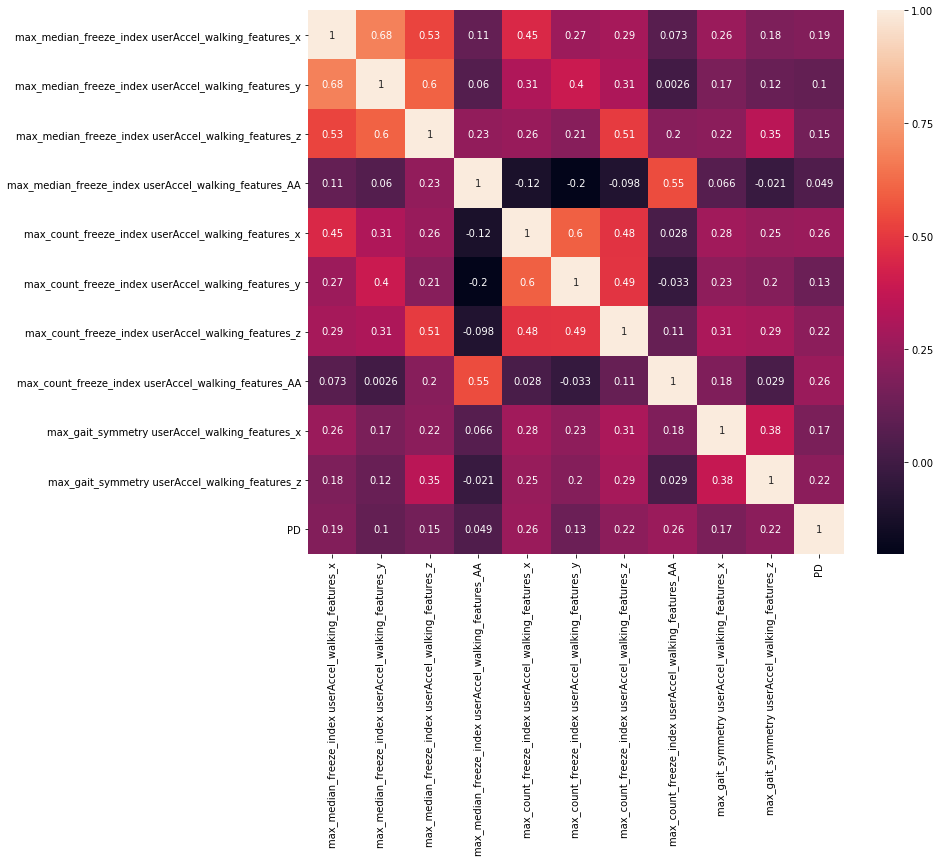

In [17]:
## check multicollinearity in features
plt.figure(figsize=(12,10))
ax = sns.heatmap(walking_data.corr(), annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Removing Multicollinearity

In [18]:
data = walking_data.copy()

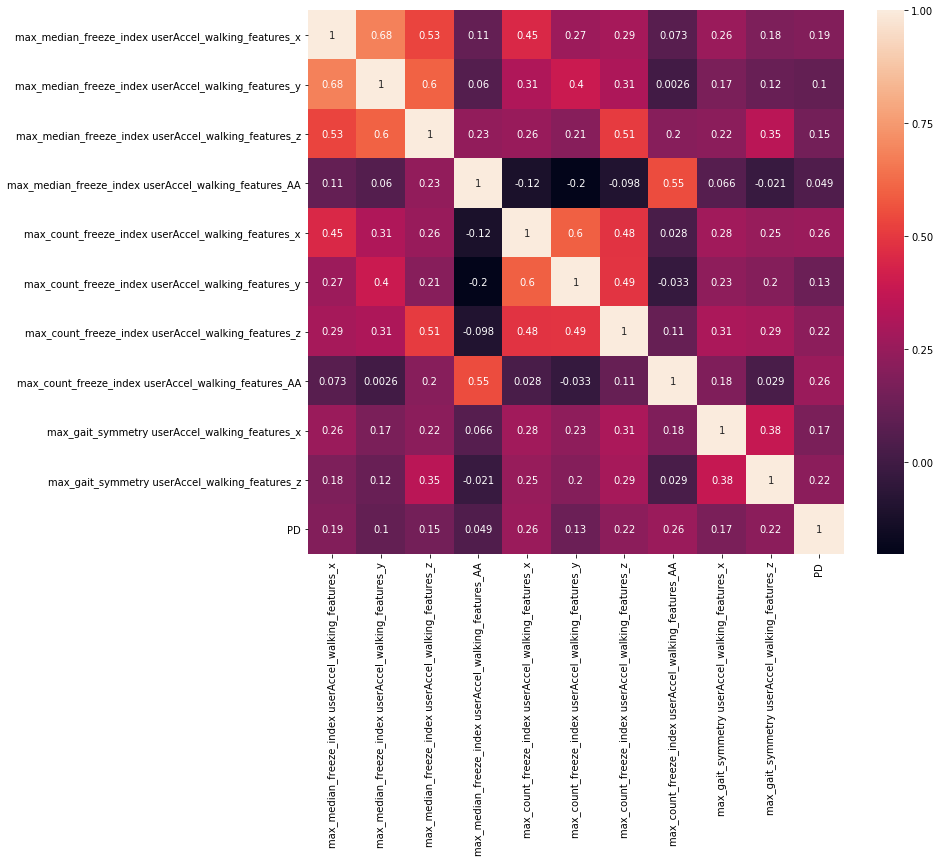

In [19]:
## check multicollinearity in features
plt.figure(figsize=(12,10))
ax = sns.heatmap(data.corr(), annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [20]:
save_data(data, "walking_data_training")

# Feature Engineering on Walking Data

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data["PD"], test_size=0.20, random_state = 100)

In [22]:
## Approach 1: maximize separation between PD and non-PDs

## fill PD with max or min that depends on features
## drop na to all test set

In [31]:
X_train.groupby("PD").agg(["mean"]).T

,PD,0,1
max_median_freeze_index userAccel_walking_features_x,mean,5.512112,7.119502
max_median_freeze_index userAccel_walking_features_y,mean,5.565882,6.527629
max_median_freeze_index userAccel_walking_features_z,mean,4.593821,6.044141
max_median_freeze_index userAccel_walking_features_AA,mean,3.097104,3.466091
max_count_freeze_index userAccel_walking_features_x,mean,33.573333,38.833333
max_count_freeze_index userAccel_walking_features_y,mean,34.360000,37.628205
max_count_freeze_index userAccel_walking_features_z,mean,30.520000,36.346154
max_count_freeze_index userAccel_walking_features_AA,mean,14.946667,18.653846
max_gait_symmetry userAccel_walking_features_x,mean,0.178924,0.204987
max_gait_symmetry userAccel_walking_features_z,mean,0.261341,0.328456


In [24]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [27]:
selector1 = SelectKBest(chi2, k=10).fit(X_train.drop(["healthCode", "PD"], axis = 1), y_train)
selector2 = SelectKBest(f_classif, k=10).fit(X_train.drop(["healthCode", "PD"], axis = 1), y_train)

In [28]:
selector1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [71]:
selector2.scores_

array([3.82053052e+00, 6.15418218e-01, 4.27351225e+00, 7.19151797e-01,
       7.80620130e+00, 1.87969284e+00, 7.91942609e+00, 9.33991032e+00,
       3.09192653e+00, 1.27671093e+01, 6.45169445e-01, 1.71771578e+00,
       8.56112964e-01, 1.81659095e+00, 9.09392174e-05, 2.24545565e+00,
       5.24164616e-01, 4.84040532e-02, 4.29651807e-01, 1.48518036e+00,
       4.39806194e-01, 3.46559154e-01])